In [51]:
import KNNclassy
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
importlib.reload(KNNclassy)

<module 'KNNclassy' from '/home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/KNNclassy.py'>

In [100]:
def SIG_NS(algo, thr):
    allprob = algo.metrics["probab"]
    v_prob_NS = 1-allprob[:,0]
    nplus = v_prob_NS*algo.optimal["k"]
    for i in range(0,len(nplus)):
        nplus[i] = int(round(nplus[i]))
    total_events = len(algo.xtest)
    events_have_NS = np.where((algo.label_test==1) | (algo.label_test==2))[0]
    N = len(events_have_NS)
    M = len(algo.label_test) - N
    index_say_yes = np.where(v_prob_NS>=thr)[0]
    index_say_no  = np.where(v_prob_NS <thr)[0]
    count = np.zeros(total_events)
    
    for i in range(0,total_events):
        if i in index_say_yes:
            if i in events_have_NS:
                count[i] = 1
            elif i not in events_have_NS:
                count[i] = 0
        elif i not in index_say_no:
            if i in events_have_NS:
                count[i] = 0
            elif i not in events_have_NS:
                count[i] = 1  
                
    Pbayes = []
    
    for i in range(0,int(algo.optimal["k"]+1)):
        indices = np.where(nplus == i)
        events_n = count[indices]
        TP = np.sum(events_n)
        FP = len(events_n)-TP
        Pbayes.append(TP/(TP+FP))
    
    return Pbayes

def SIG_REM(algo, thr):
    allprob = algo.metrics["probab"]
    v_prob_REM = allprob[:,2]
    nplus = v_prob_REM*algo.optimal["k"]
    for i in range(0,len(nplus)):
        nplus[i] = int(round(nplus[i]))
    total_events = len(algo.xtest)
    events_have_REM = np.where(algo.label_test==2)[0]
    N = len(events_have_REM)
    M = len(algo.label_test) - N
    index_say_yes = np.where(v_prob_REM>=thr)[0]
    index_say_no  = np.where(v_prob_REM <thr)[0]
    count = np.zeros(total_events)
    
    for i in range(0,total_events):
        if i in index_say_yes:
            if i in events_have_REM:
                count[i] = 1
            elif i not in events_have_REM:
                count[i] = 0
        elif i not in index_say_no:
            if i in events_have_REM:
                count[i] = 0
            elif i not in events_have_REM:
                count[i] = 1       
    
    Pbayes = []
    
    for i in range(0,int(algo.optimal["k"]+1)):
        indices = np.where(nplus == i)
        events_n = count[indices]
        TP = np.sum(events_n)
        FP = len(events_n)-TP
        Pbayes.append(TP/(TP+FP))
        
    
    return Pbayes

In [101]:
frac_testing = 0.3
nneigh = [10]
pathClassy = "/home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/"
pathData = "/home/miquelmiravet/University/Doctorat/Projects/IPAM_ML/KNN_miq/input/"
EOS = ["APR4_EPP", "BHF_BBB2", "H4", "HQC18", "KDE0V", "KDE0V1", "MPA1", "MS1_PP", "MS1B_PP", "RS", "SK255", "SK272", "SKI2", "SKI3", "SKI4", "SKI5", "SKI6", "SKMP", "SKOP", "SLy", "SLY2", "SLY9", "SLY230A"]
EOSgrey = ["APR4_EPP",  "H4", "HQC18", "KDE0V", "KDE0V1", "MPA1", "MS1B_PP", "RS", "SK255", "SK272", "SKI2", "SKI3", "SKI4", "SKI5", "SKI6", "SKMP", "SKOP", "SLY2", "SLY9", "SLY230A"]
EOScolor = ["BHF_BBB2", "MS1_PP", "SLy"]
BayesFactor = [1.526, 1.555, 0.056, 1.422, 1.177, 1.283, 0.276, 0.001, 0.009, 0.176, 0.179, 0.159, 0.108, 0.107, 0.33, 0.025, 0.288, 0.29, 0.618, 1.0, 1.028, 0.37, 0.932]

In [102]:
EOSdic = {}
sig_dic = {}
count = 0
EOS = ['SLy']

In [103]:
for eos in EOS:
    
    print("Doing", eos)
    print('*'*60)
    
    new_dic_sig = {}
    sig_dic[eos] = new_dic_sig
    
    sig_dic[eos]['NSn+'] = []
    sig_dic[eos]['REMn+'] = []
    sig_dic[eos]['NS_Pbayes'] = []
    sig_dic[eos]['REM_Pbayes'] = []

    for kk in nneigh:
        
        print("Nº of neighbors: ", kk)
        print('-'*40)

        KNN = KNNclassy.ClassificationKNN()
        KNN.load_original_dataset(pathData,eos+"/EMB/original_data_"+eos+"_s300_f0d7.csv",frac_testing)
    
        KNN.optimal = {}
        KNN.optimal["k"] = kk
        KNN.optimal["metric"] = 'manhattan'
        KNN.optimal["algo"] = 'ball_tree'
        KNN.optimal["weight"] = 'distance'

        KNN.build_train_model(KNN.optimal["k"] , KNN.optimal["metric"], KNN.optimal["algo"], KNN.optimal["weight"])
        
        new_dic = {}
        new_dic['knn'] = KNN
        new_dic['bayes'] = BayesFactor[count]
        EOSdic[eos] = new_dic
        
        KNN.compute_metrics()

        EOSdic[eos]['score'] = KNN.metrics['score']
        params_model = KNN.model.get_params()
        EOSdic[eos]['n_neigh'] = params_model.get('n_neighbors')
        EOSdic[eos]['metric'] = params_model.get('metric')
        EOSdic[eos]['algo'] = params_model.get('algorithm')
        EOSdic[eos]['weight'] = params_model.get('weights')
        
        EOSdic[eos]['NS_Pbayes'] = SIG_NS(KNN, thr = 0.5)
        EOSdic[eos]['REM_Pbayes'] = SIG_REM(KNN, thr = 0.5)
        
        sig_dic[eos]['NS_Pbayes'].append(EOSdic[eos]['NS_Pbayes'])
        sig_dic[eos]['REM_Pbayes'].append(EOSdic[eos]['REM_Pbayes'])
    
        print('*'*60)
        
    count = count + 1
        

Doing SLy
************************************************************
Nº of neighbors:  10
----------------------------------------
File shape :  (196264, 11)
[ 1.006907  1.726921  1.172679 ... 79.196968 66.51236  59.432453]
************************************************************
Loading data...
Nº of features:  5
Nº of events:  196264
Nº of events for training:  137385
Nº of events for testing:  58879
Datasets loaded!
************************************************************
************************************************************
Training model...
Training time (s) :  0.0692971390672028
************************************************************
Model score :  0.949727407055147
Predicting probabilities...
Testing time (s) :  1.8286196499830112
************************************************************


In [110]:
from scipy.optimize import curve_fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)


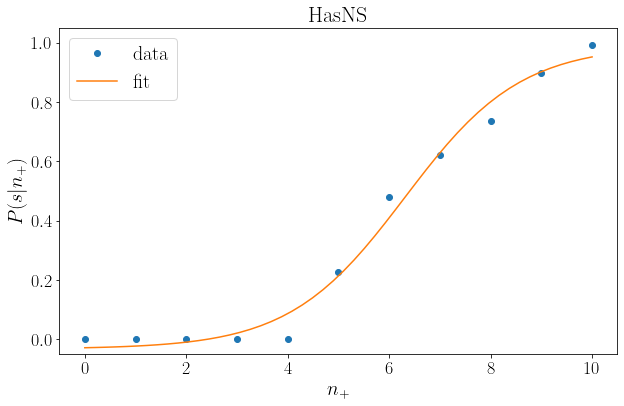

In [129]:
p0 = [max(P_bayes_NS[0,:]), np.median(n_k),1,min(P_bayes_NS[0,:])] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, n_k, P_bayes_NS[0,:],p0, method='dogbox')

x = np.linspace(0, 10, 50)
y = sigmoid(x, *popt)

plt.figure(figsize=(10,6))
plt.plot(n_k, P_bayes_NS[0,:], 'o', label='data')
plt.title('HasNS', fontsize = 22)
plt.xlabel(r'$n_+$', fontsize = 20)
plt.ylabel(r'$P(s|n_+)$', fontsize = 20)
plt.plot(x,y, label='fit')
plt.ylim(-0.05, 1.05)
plt.legend(loc='best', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

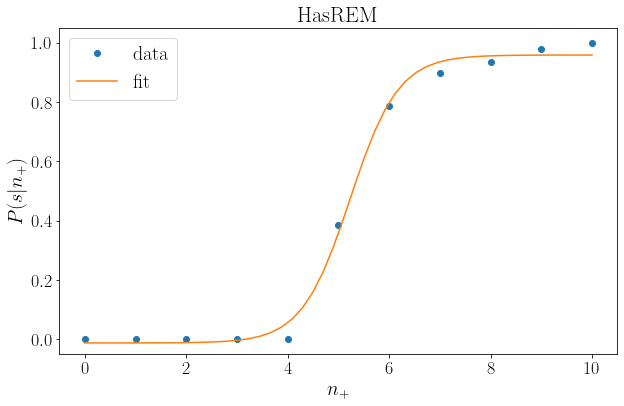

In [130]:
p0 = [max(P_bayes_REM[0,:]), np.median(n_k),1,min(P_bayes_REM[0,:])] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, n_k, P_bayes_REM[0,:],p0, method='dogbox')

x = np.linspace(0, 10, 50)
y = sigmoid(x, *popt)

plt.figure(figsize=(10,6))
plt.plot(n_k, P_bayes_REM[0,:], 'o', label='data')
plt.title('HasREM', fontsize = 22)
plt.xlabel(r'$n_+$', fontsize = 20)
plt.ylabel(r'$P(s|n_+)$', fontsize = 20)
plt.plot(x,y, label='fit')
plt.ylim(-0.05, 1.05)
plt.legend(loc='best', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()